In [1]:
import torch
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# Import transformer, tagger and trainer
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# Define columns
columns = {0: 'text', 1: 'ner'}

# Path to data
data_folder = '/home/kaester/Development/Python/Notebooks/data/'

corpus: Corpus = ColumnCorpus(data_folder, columns,
                             train_file = 'NER-de-train_outer.tsv',
                             test_file = 'NER-de-test_outer.tsv',
                             dev_file = 'NER-de-dev_outer.tsv')

print(corpus)

2022-09-16 17:14:56,541 Reading data from /home/kaester/Development/Python/Notebooks/data
2022-09-16 17:14:56,542 Train: /home/kaester/Development/Python/Notebooks/data/NER-de-train_outer.tsv
2022-09-16 17:14:56,542 Dev: /home/kaester/Development/Python/Notebooks/data/NER-de-dev_outer.tsv
2022-09-16 17:14:56,543 Test: /home/kaester/Development/Python/Notebooks/data/NER-de-test_outer.tsv
Corpus: 24000 train + 2200 dev + 5100 test sentences


In [2]:
# Create dictionary
ner_dict = corpus.make_label_dictionary(label_type='ner')

2022-09-16 17:15:03,118 Computing label dictionary. Progress:


24000it [00:00, 56288.52it/s]

2022-09-16 17:15:03,579 Dictionary created for label 'ner' with 13 values: LOC (seen 8281 times), PER (seen 7679 times), ORG (seen 5255 times), OTH (seen 3024 times), LOCderiv (seen 2808 times), ORGpart (seen 805 times), LOCpart (seen 513 times), OTHderiv (seen 236 times), OTHpart (seen 190 times), PERpart (seen 184 times), PERderiv (seen 62 times), ORGderiv (seen 41 times)


In [3]:
# Initialize transformer for fine tuning
embeddings = TransformerWordEmbeddings(model='distilbert-base-german-cased', # Pretrained model on hugging face
                                       layers="-1", # Take embeddings of last layer as inputs for our classification head
                                       subtoken_pooling="first", # Take first subtoken, if we have several for one token
                                       fine_tune=True, # Adapt pretrained parameters of the backbone as well
                                       use_context=False, # Don't use context outside of a sentence.
                                       )

# Initialize sequence tagger
tagger = SequenceTagger(embeddings=embeddings,
                        tag_dictionary=ner_dict,
                        tag_type='ner',
                        use_crf=False, # We don't wanna use a Conditional Random Field for sequence labelling
                        use_rnn=False, # We do not need a recurrent network as well.
                        reproject_embeddings=False, # It's only necessary, if we wanna finetune non-trainable embeddings!
                        )

# Initialize trainer
trainer = ModelTrainer(tagger, corpus)

2022-09-16 17:15:14,492 SequenceTagger predicts: Dictionary with 49 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-OTH, B-OTH, E-OTH, I-OTH, S-LOCderiv, B-LOCderiv, E-LOCderiv, I-LOCderiv, S-ORGpart, B-ORGpart, E-ORGpart, I-ORGpart, S-LOCpart, B-LOCpart, E-LOCpart, I-LOCpart, S-OTHderiv, B-OTHderiv, E-OTHderiv, I-OTHderiv, S-OTHpart, B-OTHpart, E-OTHpart, I-OTHpart, S-PERpart, B-PERpart, E-PERpart, I-PERpart, S-PERderiv, B-PERderiv, E-PERderiv, I-PERderiv, S-ORGderiv, B-ORGderiv, E-ORGderiv, I-ORGderiv


In [4]:
from flair.optim import LinearSchedulerWithWarmup


trainer.train('resources/taggers/germaneval14_ner/16092022-AdamW-Final',
                optimizer=torch.optim.AdamW, # State of the art optimizer for fast convergence
                learning_rate=5.0e-5, # Learning rate for our optimizer -> hopefully it fits!
                mini_batch_size=16, # Batch size, which should fit in our GPU. Smaller batch size -> more adaption steps, bit training takes longer!
                max_epochs=5, # After X epochs we are done
                scheduler=LinearSchedulerWithWarmup, # Use a warmup period and linear learning rate decrease
                checkpoint=True,
             )

2022-09-16 17:15:35,488 ----------------------------------------------------------------------------------------------------
2022-09-16 17:15:35,489 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(31102, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768

2022-09-16 17:17:15,973 epoch 1 - iter 750/1500 - loss 0.88563409 - samples/sec: 118.74 - lr: 0.000050
2022-09-16 17:17:36,250 epoch 1 - iter 900/1500 - loss 0.79441479 - samples/sec: 118.41 - lr: 0.000049
2022-09-16 17:17:56,512 epoch 1 - iter 1050/1500 - loss 0.72270564 - samples/sec: 118.50 - lr: 0.000048
2022-09-16 17:18:17,132 epoch 1 - iter 1200/1500 - loss 0.66922162 - samples/sec: 116.44 - lr: 0.000047
2022-09-16 17:18:38,098 epoch 1 - iter 1350/1500 - loss 0.62708206 - samples/sec: 114.52 - lr: 0.000046
2022-09-16 17:18:58,500 epoch 1 - iter 1500/1500 - loss 0.59333735 - samples/sec: 117.68 - lr: 0.000044
2022-09-16 17:18:58,501 ----------------------------------------------------------------------------------------------------
2022-09-16 17:18:58,502 EPOCH 1 done: loss 0.5933 - lr 0.000044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:08<00:00, 15.50it/s]


2022-09-16 17:19:07,412 Evaluating as a multi-label problem: False
2022-09-16 17:19:07,434 DEV : loss 0.09275367856025696 - f1-score (micro avg)  0.8321
2022-09-16 17:19:07,549 BAD EPOCHS (no improvement): 4
2022-09-16 17:19:08,612 saving best model
2022-09-16 17:19:09,674 ----------------------------------------------------------------------------------------------------
2022-09-16 17:19:30,524 epoch 2 - iter 150/1500 - loss 0.25975609 - samples/sec: 115.27 - lr: 0.000043
2022-09-16 17:19:51,320 epoch 2 - iter 300/1500 - loss 0.25805723 - samples/sec: 115.46 - lr: 0.000042
2022-09-16 17:20:11,993 epoch 2 - iter 450/1500 - loss 0.25599833 - samples/sec: 116.15 - lr: 0.000041
2022-09-16 17:20:32,510 epoch 2 - iter 600/1500 - loss 0.25593583 - samples/sec: 117.03 - lr: 0.000040
2022-09-16 17:20:53,324 epoch 2 - iter 750/1500 - loss 0.25615338 - samples/sec: 115.36 - lr: 0.000039
2022-09-16 17:21:13,963 epoch 2 - iter 900/1500 - loss 0.25398754 - samples/sec: 116.34 - lr: 0.000038
2022-09

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:08<00:00, 16.07it/s]

2022-09-16 17:22:45,498 Evaluating as a multi-label problem: False
2022-09-16 17:22:45,519 DEV : loss 0.08406437933444977 - f1-score (micro avg)  0.8568


2022-09-16 17:22:45,641 BAD EPOCHS (no improvement): 4
2022-09-16 17:22:46,717 saving best model
2022-09-16 17:22:49,409 ----------------------------------------------------------------------------------------------------
2022-09-16 17:23:10,173 epoch 3 - iter 150/1500 - loss 0.22311297 - samples/sec: 115.65 - lr: 0.000032
2022-09-16 17:23:30,737 epoch 3 - iter 300/1500 - loss 0.22543985 - samples/sec: 116.76 - lr: 0.000031
2022-09-16 17:23:51,422 epoch 3 - iter 450/1500 - loss 0.22366884 - samples/sec: 116.08 - lr: 0.000030
2022-09-16 17:24:12,310 epoch 3 - iter 600/1500 - loss 0.22469814 - samples/sec: 114.95 - lr: 0.000029
2022-09-16 17:24:33,150 epoch 3 - iter 750/1500 - loss 0.22493853 - samples/sec: 115.22 - lr: 0.000028
2022-09-16 17:24:54,590 epoch 3 - iter 900/1500 - loss 0.22405679 - samples/sec: 111.99 - lr: 0.000027
2022-09-16 17:25:15,445 epoch 3 - iter 1050/1500 - loss 0.22304996 - samples/sec: 115.13 - lr: 0.000026
2022-09-16 17:25:36,472 epoch 3 - iter 1200/1500 - loss 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:07<00:00, 17.35it/s]

2022-09-16 17:26:26,452 Evaluating as a multi-label problem: False


2022-09-16 17:26:26,473 DEV : loss 0.10170043259859085 - f1-score (micro avg)  0.8602
2022-09-16 17:26:26,592 BAD EPOCHS (no improvement): 4
2022-09-16 17:26:28,352 saving best model
2022-09-16 17:26:31,022 ----------------------------------------------------------------------------------------------------
2022-09-16 17:26:51,756 epoch 4 - iter 150/1500 - loss 0.20195900 - samples/sec: 115.83 - lr: 0.000021
2022-09-16 17:27:12,603 epoch 4 - iter 300/1500 - loss 0.20570129 - samples/sec: 115.18 - lr: 0.000020
2022-09-16 17:27:33,277 epoch 4 - iter 450/1500 - loss 0.20848097 - samples/sec: 116.14 - lr: 0.000019
2022-09-16 17:27:54,038 epoch 4 - iter 600/1500 - loss 0.20831535 - samples/sec: 115.65 - lr: 0.000018
2022-09-16 17:28:14,808 epoch 4 - iter 750/1500 - loss 0.20885699 - samples/sec: 115.61 - lr: 0.000017
2022-09-16 17:28:35,646 epoch 4 - iter 900/1500 - loss 0.20851746 - samples/sec: 115.22 - lr: 0.000016
2022-09-16 17:28:56,832 epoch 4 - iter 1050/1500 - loss 0.20693659 - sampl

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:08<00:00, 15.95it/s]

2022-09-16 17:30:07,576 Evaluating as a multi-label problem: False


2022-09-16 17:30:07,598 DEV : loss 0.11378999054431915 - f1-score (micro avg)  0.8624
2022-09-16 17:30:07,719 BAD EPOCHS (no improvement): 4
2022-09-16 17:30:10,394 saving best model
2022-09-16 17:30:13,063 ----------------------------------------------------------------------------------------------------
2022-09-16 17:30:33,865 epoch 5 - iter 150/1500 - loss 0.20311391 - samples/sec: 115.43 - lr: 0.000010
2022-09-16 17:30:54,800 epoch 5 - iter 300/1500 - loss 0.19872436 - samples/sec: 114.70 - lr: 0.000009
2022-09-16 17:31:15,513 epoch 5 - iter 450/1500 - loss 0.19608308 - samples/sec: 115.92 - lr: 0.000008
2022-09-16 17:31:36,302 epoch 5 - iter 600/1500 - loss 0.19569000 - samples/sec: 115.50 - lr: 0.000007
2022-09-16 17:31:57,115 epoch 5 - iter 750/1500 - loss 0.19730137 - samples/sec: 115.36 - lr: 0.000006
2022-09-16 17:32:18,118 epoch 5 - iter 900/1500 - loss 0.19749618 - samples/sec: 114.32 - lr: 0.000004
2022-09-16 17:32:39,494 epoch 5 - iter 1050/1500 - loss 0.19736896 - sampl

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:07<00:00, 17.57it/s]

2022-09-16 17:33:49,866 Evaluating as a multi-label problem: False


2022-09-16 17:33:49,888 DEV : loss 0.12510038912296295 - f1-score (micro avg)  0.8667
2022-09-16 17:33:50,006 BAD EPOCHS (no improvement): 4
2022-09-16 17:33:52,725 saving best model
2022-09-16 17:33:56,461 ----------------------------------------------------------------------------------------------------
2022-09-16 17:33:56,462 loading file resources/taggers/germaneval14_ner/16092022-AdamW-Final/best-model.pt
2022-09-16 17:33:58,567 SequenceTagger predicts: Dictionary with 49 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-OTH, B-OTH, E-OTH, I-OTH, S-LOCderiv, B-LOCderiv, E-LOCderiv, I-LOCderiv, S-ORGpart, B-ORGpart, E-ORGpart, I-ORGpart, S-LOCpart, B-LOCpart, E-LOCpart, I-LOCpart, S-OTHderiv, B-OTHderiv, E-OTHderiv, I-OTHderiv, S-OTHpart, B-OTHpart, E-OTHpart, I-OTHpart, S-PERpart, B-PERpart, E-PERpart, I-PERpart, S-PERderiv, B-PERderiv, E-PERderiv, I-PERderiv, S-ORGderiv, B-ORGderiv, E-ORGderiv, I-ORGderiv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:17<00:00, 17.88it/s]

2022-09-16 17:34:16,531 Evaluating as a multi-label problem: False
2022-09-16 17:34:16,570 0.8512	0.8548	0.853	0.778
2022-09-16 17:34:16,571 
Results:
- F-score (micro) 0.853
- F-score (macro) 0.6603
- Accuracy 0.778

By class:
              precision    recall  f1-score   support

         LOC     0.8983    0.9109    0.9045      1706
         PER     0.9328    0.9408    0.9368      1639
         ORG     0.8031    0.8017    0.8024      1150
         OTH     0.6883    0.6557    0.6716       697
    LOCderiv     0.8699    0.9412    0.9041       561
     ORGpart     0.7514    0.7558    0.7536       172
     LOCpart     0.7212    0.6881    0.7042       109
     OTHpart     0.5682    0.5952    0.5814        42
     PERpart     0.6571    0.5227    0.5823        44
    OTHderiv     0.5833    0.5385    0.5600        39
    PERderiv     0.3333    0.2727    0.3000        11
    ORGderiv     1.0000    0.1250    0.2222         8

   micro avg     0.8512    0.8548    0.8530      6178
   macro avg  

{'test_score': 0.8530124374091422,
 'dev_score_history': [0.8321194464675892,
  0.8567727609178386,
  0.8601991884913317,
  0.8623988226637234,
  0.8667157584683357],
 'train_loss_history': [0.5933373476021749,
  0.2542871291452526,
  0.22252825641207316,
  0.20803980023468496,
  0.1972436731842335],
 'dev_loss_history': [0.09275367856025696,
  0.08406437933444977,
  0.10170043259859085,
  0.11378999054431915,
  0.12510038912296295]}

2022-09-16 17:37:24,356 ----------------------------------------------------------------------------------------------------
2022-09-16 17:37:24,356 WARNING: No LOSS found for test split in this data.
2022-09-16 17:37:24,357 Are you sure you want to plot LOSS and not another value?
2022-09-16 17:37:24,357 ----------------------------------------------------------------------------------------------------
2022-09-16 17:37:24,373 ----------------------------------------------------------------------------------------------------
2022-09-16 17:37:24,373 WARNING: No F1 found for test split in this data.
2022-09-16 17:37:24,374 Are you sure you want to plot F1 and not another value?
2022-09-16 17:37:24,374 ----------------------------------------------------------------------------------------------------
2022-09-16 17:37:25,180 Loss and F1 plots are saved in resources/taggers/germaneval14_ner/16092022-AdamW-Final/training.png


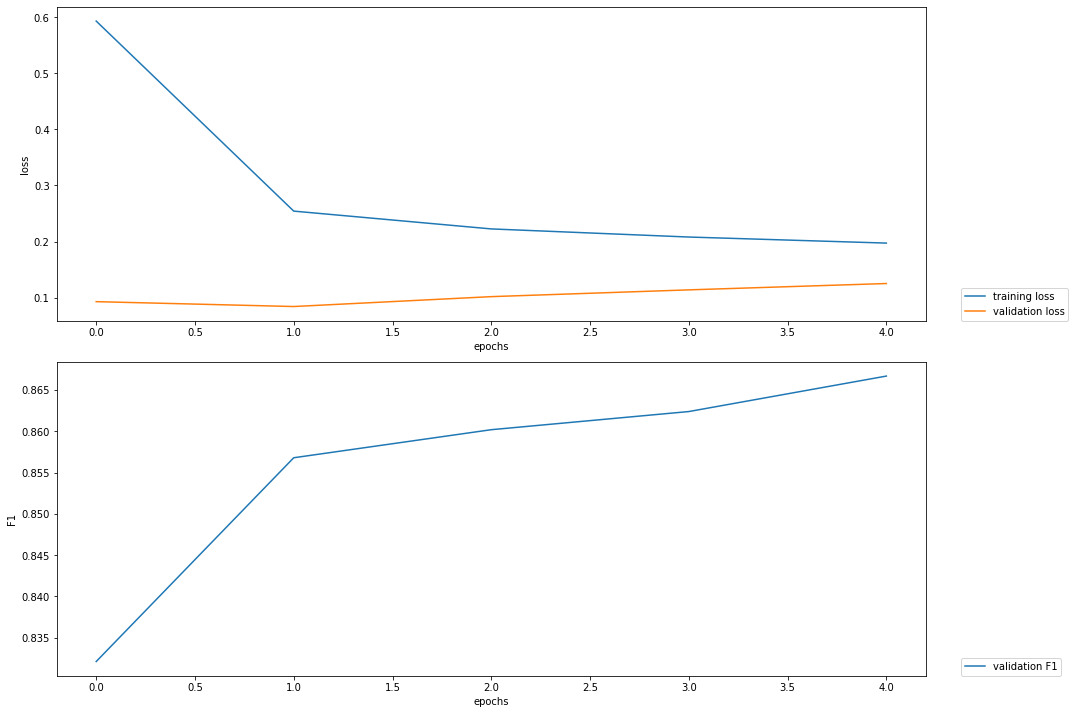

In [6]:
# Show curves
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('resources/taggers/germaneval14_ner/16092022-AdamW-Final/loss.tsv')